## Note that this notebook needs PyRossGeo to run 

So we first install the latest PyPI version from 
https://pypi.org/project/PyRossGeo/

We also install the latest local version of PyRoss

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../../')
%run setup.py install
os.chdir(owd)

!pip install pyrossgeo

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo
import pyross
import time 
import pandas as pd
import json

## Convert from geo model spec to pyross model spec 

In [3]:
with open('./SIR_network/model.json', 'r') as f:
    geo_model_spec = json.load(f)
    
classes = geo_model_spec['settings']['classes']
classes.remove('R')


model_spec = {} 
model_spec['classes'] = classes 
for c in classes: 
    model_spec[c] = geo_model_spec[c]
    
print(model_spec)

{'classes': ['S', 'I'], 'S': {'linear': [], 'infection': [['I', '-beta']]}, 'I': {'linear': [['I', '-gamma']], 'infection': [['I', 'beta']]}}


## Read in model parameters 

In [4]:
df = pd.read_csv('./SIR_network/node_parameters.csv')

parameters = {
    'beta': df['beta'].values[0], 
    'gamma': df['gamma'].values[0], 
}

areas = np.array([df['Area'].values[0]]*3)

print(parameters, areas)
df

{'beta': 0.01, 'gamma': 0.03} [1 1 1]


,Home,Location,Age,Area,beta,gamma
0,ALL,ALL,ALL,1,0.01,0.03


## Read in the overall contact matrix 

In [5]:
with open('./SIR_network/contact_matrices.json', 'r') as f:
    CM_dict = json.load(f)
    
print(CM_dict)

CM =  np.array(CM_dict['C_main'])*60*24

CM 

{'C_main': [[0.002, 0.008, 0.002], [0.004, 0.007, 0.001], [0.002, 0.009, 0.002]]}


array([[ 2.88, 11.52,  2.88],
       [ 5.76, 10.08,  1.44],
       [ 2.88, 12.96,  2.88]])

## Read in the note populations and initial conditions 

In [6]:
data = pd.read_csv('./SIR_network/node_populations.csv').values

M = 3 # three age groups
n_loc = 3 # number of nodes 
x0 = np.empty((2, n_loc, M)) # S, I * n_loc * M 
for mu in range(n_loc):
    for m in range(2):
        for i in range(M):
            x0[m, mu, i] = data[mu, 2+3*i+m]

populations = np.sum(x0, axis=0)

##  Defining the commuter network

In [7]:
df = pd.read_csv('./SIR_network/commuter_networks.csv')

to_move = df["# to move"].values 
age = df["Age"].values 
loc_home = df["From"].values 
loc_work = df["To"].values

commutes = np.zeros((n_loc, n_loc, M))
for i in range(0, len(age), 2):
    v = to_move[i]
    age_group = int(age[i]) 
    l1 = int(loc_home[i])
    l2 = int(loc_work[i]) 
    commutes[l1, l2, age_group] = v 
    
    
work_ratio = 10/24  
df

,Home,From,To,Age,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow I,Allow R
0,0,0,1,0,210,-1,7,8,8,9,1,1,1
1,0,1,0,0,-1,1,17,18,18,19,1,1,1
2,0,0,2,1,500,-1,7,8,8,9,1,1,1
3,0,2,0,1,-1,1,17,18,18,19,1,1,1
4,1,1,0,1,100,-1,7,8,8,9,1,1,1
5,1,0,1,1,-1,1,17,18,18,19,1,1,1
6,2,2,1,0,300,-1,7,8,8,9,1,1,1
7,2,1,2,0,-1,1,17,18,18,19,1,1,1


## Set up contact matrix and use spatial contact matrix to simulate in PyRoss 

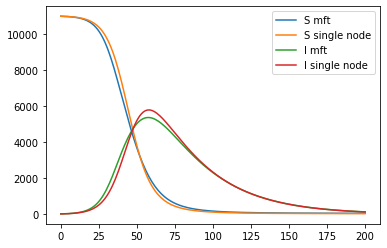

In [8]:
generator = pyross.contactMatrix.SpatialContactMatrix(1, work_ratio, populations, areas, commutes)
spatial_CM = generator.spatial_contact_matrix(CM).reshape((n_loc*M, n_loc*M))

def contactMatrix(t):
    return spatial_CM 

Tf = 200
Nf = Tf+1

model = pyross.deterministic.Spp(model_spec, parameters, n_loc*M, populations.flatten())

data = model.simulate(x0.flatten(), contactMatrix, Tf, Nf)

S_mft = np.sum(model.model_class_data('S', data), axis=1)
I_mft = np.sum(model.model_class_data('I', data), axis=1)

S_by_age = np.sum(model.model_class_data('S', data).reshape((Nf, n_loc, M)), axis=1)
I_by_age = np.sum(model.model_class_data('I', data).reshape((Nf, n_loc, M)), axis=1)


# compare again single node 

def national_contactMatrix(t):
    return CM 
sn_model = pyross.deterministic.Spp(model_spec, parameters, M, np.sum(populations, axis=0))
sn_data = sn_model.simulate(np.sum(x0, axis=1).flatten(), national_contactMatrix, Tf, Nf)

S_sn = np.sum(sn_model.model_class_data('S', sn_data), axis=1)
I_sn = np.sum(sn_model.model_class_data('I', sn_data), axis=1)


plt.plot(S_mft, label='S mft')
plt.plot(S_sn, label='S single node')
plt.plot(I_mft, label='I mft')
plt.plot(I_sn, label='I single node')
plt.legend()
plt.show()

### Simulating the network in PyRossGeo

In [9]:
ts, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  2*60),     # Use a 2h time-step between 0-7
    (5*60,  1),     # Use a 10min time-step between 5-11
    (11*60, 2*60),  # Use a 2h time-step between 11-16
    (16*60, 1),     # Use a 10min time-step between 16-22
    (22*60, 2*60)   # Use a 2h time-step between 22-24
], end_time=24*60)

In [10]:
t_start = 0
t_end = 24*60*200 # Run for 200 days

sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SIR_network')

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1, steps_per_print=len(dts)*10)

Stochastic thresholds not defined. Will simulate deterministically.
Assuming contacts scale as a powerlaw, with parameters [0.0, 1.0, 0.5]
Step 0 out of 145400
Step 7270 out of 145400
Step 14540 out of 145400
Step 21810 out of 145400
Step 29080 out of 145400
Step 36350 out of 145400
Step 43620 out of 145400
Step 50890 out of 145400
Step 58160 out of 145400
Step 65430 out of 145400
Step 72700 out of 145400
Step 79970 out of 145400
Step 87240 out of 145400
Step 94510 out of 145400
Step 101780 out of 145400
Step 109050 out of 145400
Step 116320 out of 145400
Step 123590 out of 145400
Step 130860 out of 145400
Step 138130 out of 145400


Various relevant data can be extracted from the simulation output `sim_data` using the function `pyrossgeo.utils.extract_simulation_data`.

In [11]:
ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

## Plot the result from PyRossGeo against previous mft and single node results 

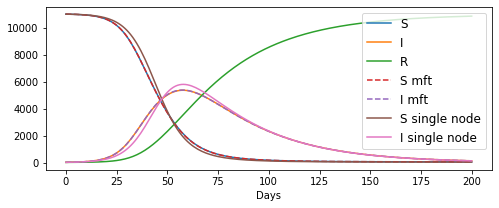

In [12]:
gap = len(dts)
ts_days = ts[::gap]/(24*60)

plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1) # Sum over all age-groups
I = np.sum(network_data[:,:,1], axis=1)
R = np.sum(network_data[:,:,2], axis=1)

plt.plot(ts_days, S[::gap], label="S")
plt.plot(ts_days, I[::gap], label="I")
plt.plot(ts_days, R[::gap], label="R")


t_in_days = np.linspace(0, 200, 201)
plt.plot(t_in_days, S_mft, label='S mft', linestyle='--')
plt.plot(t_in_days, I_mft, label='I mft', linestyle='--')

plt.plot(t_in_days, S_sn, label='S single node')
plt.plot(t_in_days, I_sn, label='I single node')

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')
plt.show()

## Out of curiosity, now see if inference can fit the spatial SIR with a well mixed SIR 

In [13]:
N = np.sum(populations)
fi = np.sum(populations, axis=0)/N 
steps = 4 
estimator = pyross.inference.Spp(model_spec, parameters, M, fi, N, steps)

# check logp for correct parameters 
x = np.sum(data['X'].reshape((Nf, 2, n_loc, M)), axis=2).reshape((Nf, 2*M))/N

logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, national_contactMatrix, tangent=False)
print(logp)

-9197.061501708095


In [14]:
## inference 
eps = 1e-4 

beta_g = parameters['beta']
beta_std = beta_g 
beta_b = (eps, 1)

gamma_g = parameters['gamma']
gamma_std = gamma_g 
gamma_b = (eps, 1)

ftol = 1e-6  # Stopping criterion for minimisation (realtive change in function value)
keys = ['beta', 'gamma']
guess = np.array([beta_g, gamma_g]) 
stds = np.array([beta_std, gamma_std]) 
bounds = np.array([beta_b, gamma_b])
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf, Nf, national_contactMatrix, 
                                    tangent=False, 
                                    global_max_iter=30, local_max_iter=200, 
                                    global_ftol_factor=1e2, ftol=ftol, verbose=True)

print(params) # best guess 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 2 (seed=307956292, Tue Jun  9 13:45:56 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -9.106256777313629e+03 1.0e+00 7.87e-01  7e-03  2e-02 0:01.8
    2     32 -9.170653274367085e+03 1.4e+00 6.84e-01  5e-03  1e-02 0:03.2
    3     48 -9.132879764733611e+03 1.5e+00 5.96e-01  4e-03  8e-03 0:04.6
    6     96 -9.255057809857924e+03 1.3e+00 4.44e-01  2e-03  3e-03 0:08.5
    9    144 -9.262440691072376e+03 1.4e+00 1.98e-01  4e-04  6e-04 0:12.8
   13    208 -9.263625597977683e+03 1.9e+00 1.31e-01  1e-04  2e-04 0:19.2
   16    256 -9.263639658272075e+03 2.7e+00 8.29e-02  5e-05  6e-05 0:23.8
Optimal value (global minimisation):  -9263.639658272075
Starting local minimisation...
Optimal value (local minimisation):  -9263.6411070049
[0.00903588 0.02930867]


In [15]:
best_estimates = {'beta': params[0], 'gamma': params[1]}
logp = estimator.obtain_minus_log_p(best_estimates, x, Tf, Nf, national_contactMatrix, tangent=False)
print(logp)

-9256.994791889349


In [16]:
hess = estimator.compute_hessian(keys, params, guess, stds, x, Tf, Nf, national_contactMatrix, eps=1.e-4, tangent=False)

In [17]:
cov = np.linalg.inv(hess)

n_sim = 50

sto_model = pyross.stochastic.Spp(model_spec, best_estimates, M, np.sum(populations, axis=0))
trajs = np.empty((n_sim, Nf, 2))
sample_parameters = np.random.multivariate_normal(params, cov, n_sim)

inits = x[20]*N

for i in range(n_sim):
    while (sample_parameters[i] < 0).any():
        sample_parameters[i] = np.random.multivariate_normal(means,cov)
    p = {'beta':sample_parameters[i,0], 
                  'gamma': sample_parameters[i,1]}
    sto_model.update_model_parameters(p)
    cur_result = sto_model.simulate(inits, national_contactMatrix, Tf, Nf)
    trajs[i, :, 0] = np.sum(sto_model.model_class_data('S', cur_result), axis=-1)
    trajs[i, :, 1] = np.sum(sto_model.model_class_data('I', cur_result), axis=-1)
    

medium = np.percentile(trajs, 50, axis=0)
lower = np.percentile(trajs, 5, axis=0)
upper = np.percentile(trajs, 95, axis=0)


sto_model_sn = pyross.stochastic.Spp(model_spec, parameters, M, np.sum(populations, axis=0))

n_sim = 20 
trajs_sn = np.empty((n_sim, Nf, 2))
for n in range(n_sim):
    sto_data_sn = sto_model_sn.simulate(inits, national_contactMatrix, Tf, Nf)
    trajs_sn[n, :, 0] = np.sum(sto_model.model_class_data('S', sto_data_sn), axis=-1)
    trajs_sn[n, :, 1] = np.sum(sto_model.model_class_data('I', sto_data_sn), axis=-1)
medium_sn = np.percentile(trajs_sn, 50, axis=0)
lower_sn = np.percentile(trajs_sn, 5, axis=0)
upper_sn = np.percentile(trajs_sn, 95, axis=0)

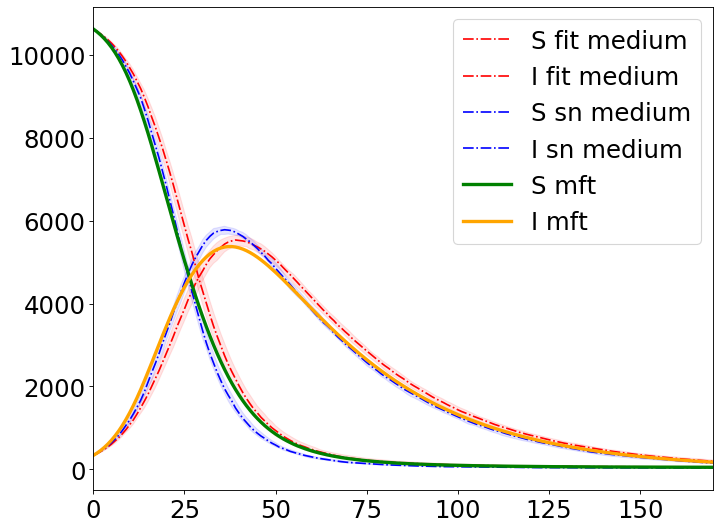

In [18]:
t = np.linspace(0, Tf, Nf)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(medium[:, 0], linestyle='-.', color='red', label='S fit medium')
plt.plot(medium[:, 1], linestyle='-.', color='red', label='I fit medium')
plt.fill_between(t, lower[:, 0], upper[:, 0], alpha=0.1, color='red')
plt.fill_between(t, lower[:, 1], upper[:, 1], alpha=0.1, color='red')
plt.plot(medium_sn[:, 0], linestyle='-.', color='blue', label='S sn medium')
plt.plot(medium_sn[:, 1], linestyle='-.', color='blue', label='I sn medium')
plt.fill_between(t, lower_sn[:, 0], upper_sn[:, 0], alpha=0.1, color='blue')
plt.fill_between(t, lower_sn[:, 1], upper_sn[:, 1], alpha=0.1, color='blue')
plt.plot(S_mft[20:], linewidth=3, color='green', label='S mft')
plt.plot(I_mft[20:], linewidth=3, color='orange', label='I mft')
plt.xlim([0, 170])
plt.legend()
plt.show()